# TrustCheckAI: Bias and Compliance Monitoring for AI Models
## Complete Implementation Pipeline

This notebook implements a comprehensive bias detection and fairness evaluation system for AI/ML models.

**Project Objectives:**
- Detect and evaluate bias in structured datasets
- Implement fairness metrics using IBM AIF360
- Provide explainability using LIME and SHAP
- Generate compliance reports

**Datasets:**
- COMPAS (Criminal Justice)
- UCI Adult Income (Finance/Employment)

## 1. Environment Setup and Package Installation

In [11]:
# Install required packages
!pip install --quiet --no-input aif360 lime shap pandas numpy scikit-learn matplotlib seaborn plotly gdown
print("-> All packages installed successfully")

-> All packages installed successfully


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import json

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# AIF360 for Fairness
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# Explainability
import shap
from lime.lime_tabular import LimeTabularExplainer

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("-> All libraries imported successfully")
#print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

/opt/homebrew/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/homebrew/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_disc

-> All libraries imported successfully


## 2. Dataset Download and Loading
### 2.1 COMPAS Dataset (Criminal Justice)

In [3]:
# Download COMPAS dataset from ProPublica
import urllib.request

print("Downloading COMPAS dataset...")
compas_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
urllib.request.urlretrieve(compas_url, 'compas-scores-two-years.csv')

# Load dataset
compas_df = pd.read_csv('compas-scores-two-years.csv')
print(f"-> COMPAS dataset loaded: {compas_df.shape[0]} rows, {compas_df.shape[1]} columns")
print("\nFirst few rows:")
compas_df.head()

-> COMPAS dataset loaded: 7214 rows, 53 columns

First few rows:


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### 2.2 UCI Adult Income Dataset

In [4]:
# Download Adult dataset from UCI repository
print("Downloading UCI Adult Income dataset...")
adult_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Column names for Adult dataset
adult_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                 'marital-status', 'occupation', 'relationship', 'race', 'sex',
                 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

adult_df = pd.read_csv(adult_url, names=adult_columns, sep=',\s*', engine='python', na_values='?')
print(f" Adult dataset loaded: {adult_df.shape[0]} rows, {adult_df.shape[1]} columns")
print("\nFirst few rows:")
adult_df.head()

 Adult dataset loaded: 32561 rows, 15 columns

First few rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 2.3 Dataset Information

In [5]:
print("="*80)
print("COMPAS DATASET INFORMATION")
print("="*80)
print(compas_df.info())
print("\nMissing Values:")
print(compas_df.isnull().sum())
print("\nStatistical Summary:")
print(compas_df.describe())

print("\n" + "="*80)
print("ADULT DATASET INFORMATION")
print("="*80)
print(adult_df.info())
print("\nMissing Values:")
print(adult_df.isnull().sum())
print("\nStatistical Summary:")
print(adult_df.describe())

COMPAS DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 1

## 3. Data Preprocessing and Cleaning
### 3.1 COMPAS Dataset Preprocessing

In [6]:
print("Preprocessing COMPAS dataset...")

# Filter dataset as per standard COMPAS analysis
compas_clean = compas_df[
    (compas_df['days_b_screening_arrest'] <= 30) &
    (compas_df['days_b_screening_arrest'] >= -30) &
    (compas_df['is_recid'] != -1) &
    (compas_df['c_charge_degree'] != 'O') &
    (compas_df['score_text'] != 'N/A')
]

# Select relevant features
compas_features = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 
                   'sex', 'priors_count', 'days_b_screening_arrest', 
                   'decile_score', 'is_recid', 'two_year_recid']

compas_clean = compas_clean[compas_features].copy()

# Handle missing values
compas_clean = compas_clean.dropna()

# Create binary target variable
compas_clean['target'] = compas_clean['two_year_recid']

# Encode categorical variables
le_dict = {}
categorical_cols = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex']

for col in categorical_cols:
    le = LabelEncoder()
    compas_clean[col + '_encoded'] = le.fit_transform(compas_clean[col])
    le_dict[col] = le

# Define protected attribute (race: African-American vs Others)
compas_clean['race_binary'] = (compas_clean['race'] == 'African-American').astype(int)

print(f" COMPAS preprocessing complete: {compas_clean.shape[0]} rows retained")
print(f"  - Target variable distribution:")
print(compas_clean['target'].value_counts())
print(f"  - Protected attribute (race) distribution:")
print(compas_clean['race'].value_counts())

Preprocessing COMPAS dataset...
 COMPAS preprocessing complete: 6172 rows retained
  - Target variable distribution:
target
0    3363
1    2809
Name: count, dtype: int64
  - Protected attribute (race) distribution:
race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64


### 3.2 Adult Dataset Preprocessing

In [7]:
print("Preprocessing Adult Income dataset...")

# Handle missing values
adult_clean = adult_df.dropna().copy()

# Create binary target variable (>50K = 1, <=50K = 0)
adult_clean['target'] = (adult_clean['income'] == '>50K').astype(int)

# Encode categorical variables
adult_le_dict = {}
adult_categorical = ['workclass', 'education', 'marital-status', 'occupation', 
                     'relationship', 'race', 'sex', 'native-country']

for col in adult_categorical:
    le = LabelEncoder()
    adult_clean[col + '_encoded'] = le.fit_transform(adult_clean[col])
    adult_le_dict[col] = le

# Define protected attributes
adult_clean['sex_binary'] = (adult_clean['sex'] == 'Male').astype(int)
adult_clean['race_binary'] = (adult_clean['race'] == 'White').astype(int)

print(f" Adult preprocessing complete: {adult_clean.shape[0]} rows retained")
print(f"  - Target variable distribution:")
print(adult_clean['target'].value_counts())
print(f"  - Protected attribute (sex) distribution:")
print(adult_clean['sex'].value_counts())
print(f"  - Protected attribute (race) distribution:")
print(adult_clean['race'].value_counts())

Preprocessing Adult Income dataset...
 Adult preprocessing complete: 30162 rows retained
  - Target variable distribution:
target
0    22654
1     7508
Name: count, dtype: int64
  - Protected attribute (sex) distribution:
sex
Male      20380
Female     9782
Name: count, dtype: int64
  - Protected attribute (race) distribution:
race
White                 25933
Black                  2817
Asian-Pac-Islander      895
Amer-Indian-Eskimo      286
Other                   231
Name: count, dtype: int64


## 4. Exploratory Data Analysis (EDA)
### 4.1 COMPAS Dataset EDA

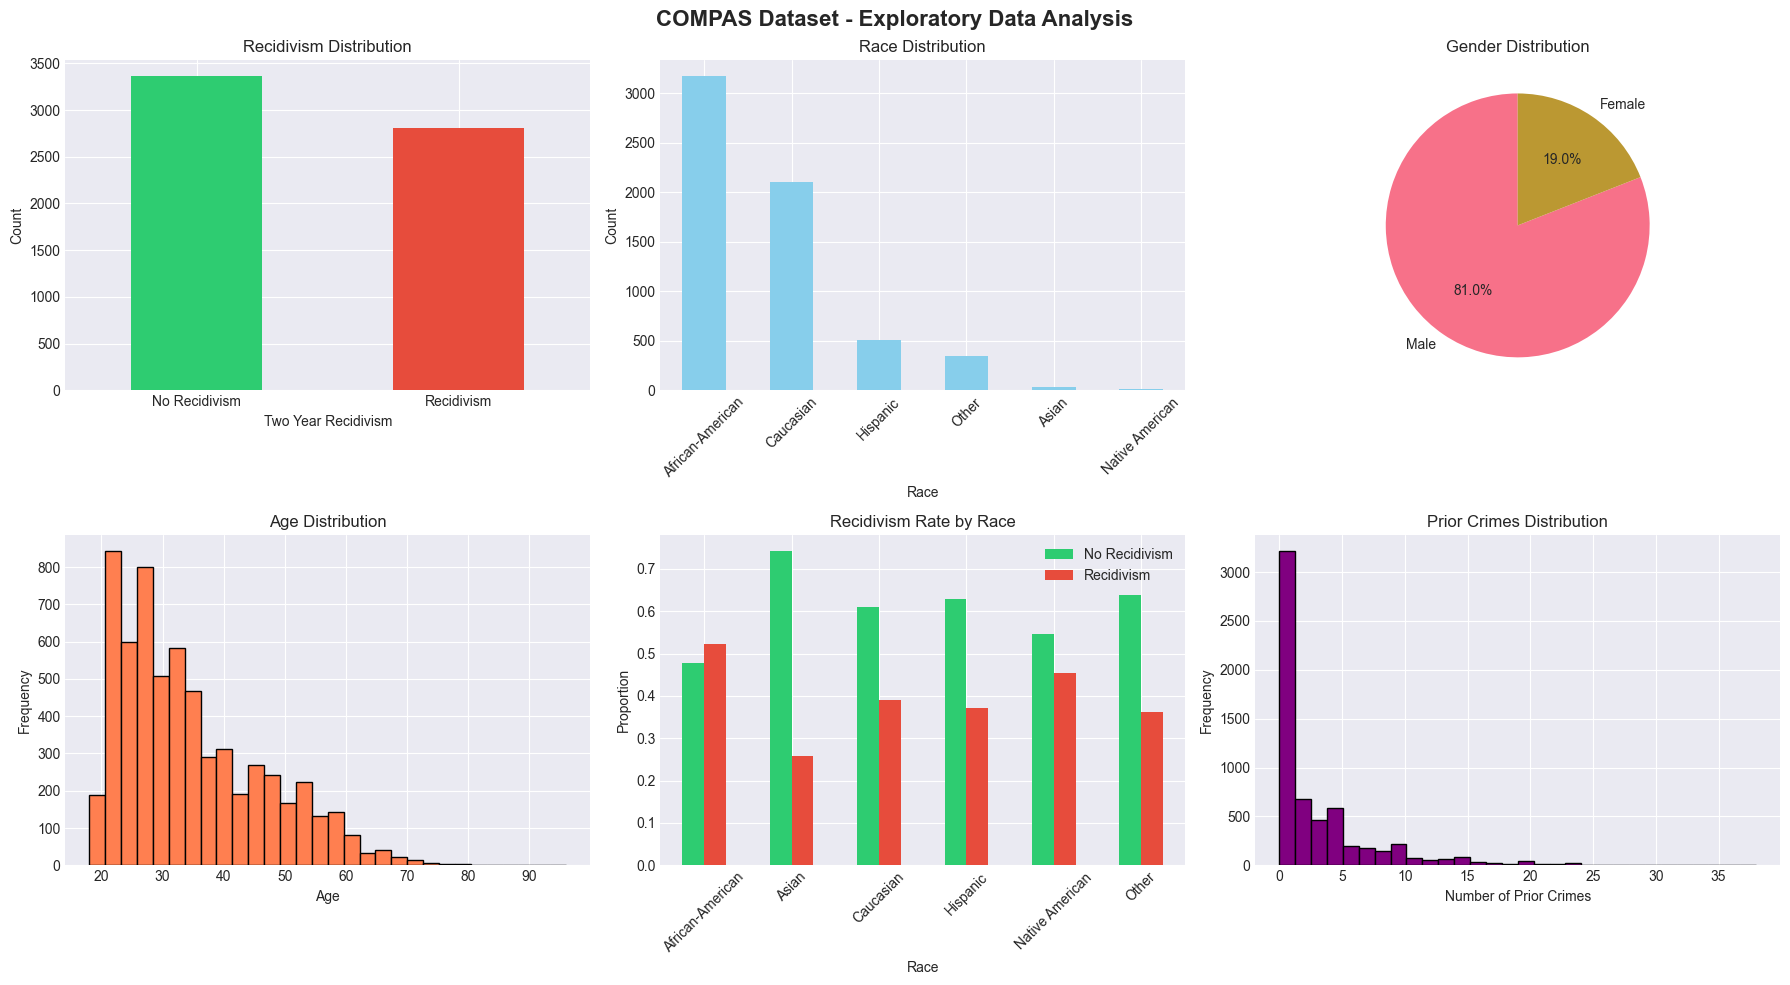

 COMPAS EDA visualizations complete


In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('COMPAS Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Target distribution
compas_clean['target'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#2ecc71', '#e74c3c'])
axes[0,0].set_title('Recidivism Distribution')
axes[0,0].set_xlabel('Two Year Recidivism')
axes[0,0].set_ylabel('Count')
axes[0,0].set_xticklabels(['No Recidivism', 'Recidivism'], rotation=0)

# 2. Race distribution
compas_clean['race'].value_counts().plot(kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Race Distribution')
axes[0,1].set_xlabel('Race')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Gender distribution
compas_clean['sex'].value_counts().plot(kind='pie', ax=axes[0,2], autopct='%1.1f%%', startangle=90)
axes[0,2].set_title('Gender Distribution')
axes[0,2].set_ylabel('')

# 4. Age distribution
axes[1,0].hist(compas_clean['age'], bins=30, color='coral', edgecolor='black')
axes[1,0].set_title('Age Distribution')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Frequency')

# 5. Recidivism by Race
pd.crosstab(compas_clean['race'], compas_clean['target'], normalize='index').plot(
    kind='bar', ax=axes[1,1], stacked=False, color=['#2ecc71', '#e74c3c'])
axes[1,1].set_title('Recidivism Rate by Race')
axes[1,1].set_xlabel('Race')
axes[1,1].set_ylabel('Proportion')
axes[1,1].legend(['No Recidivism', 'Recidivism'])
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Prior Crimes distribution
axes[1,2].hist(compas_clean['priors_count'], bins=30, color='purple', edgecolor='black')
axes[1,2].set_title('Prior Crimes Distribution')
axes[1,2].set_xlabel('Number of Prior Crimes')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(" COMPAS EDA visualizations complete")

### 4.2 Adult Dataset EDA

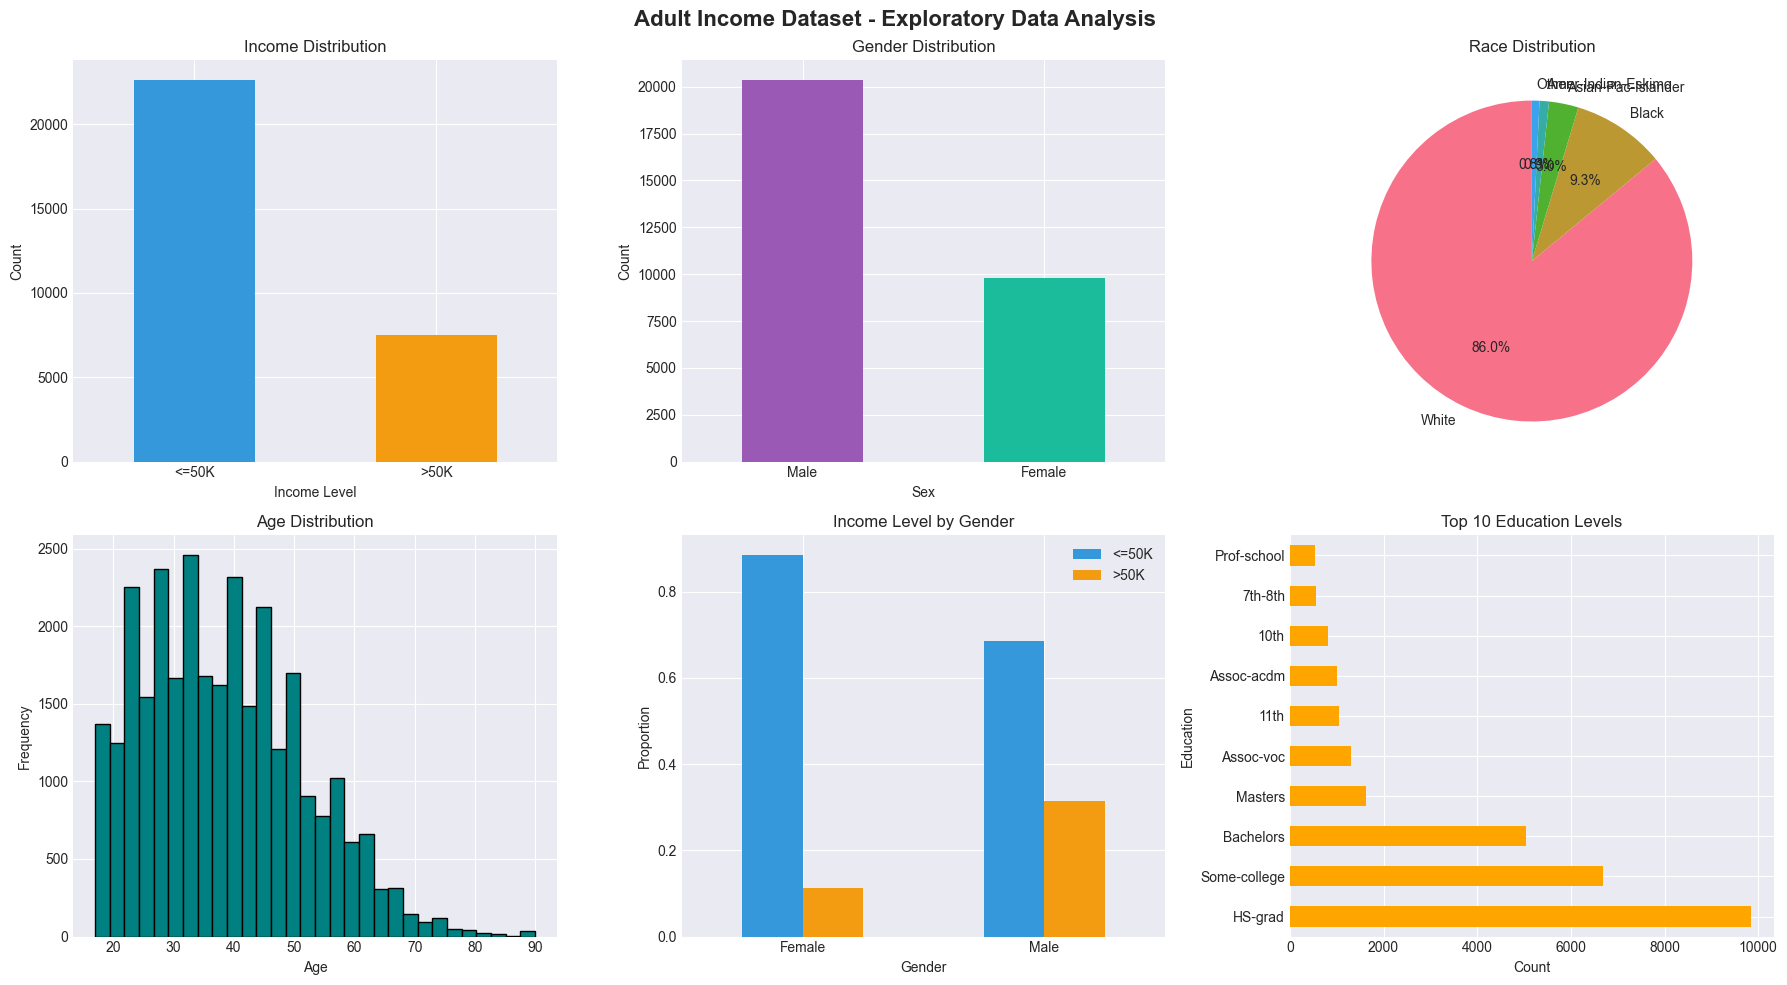

 Adult dataset EDA visualizations complete


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Adult Income Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Income distribution
adult_clean['target'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#3498db', '#f39c12'])
axes[0,0].set_title('Income Distribution')
axes[0,0].set_xlabel('Income Level')
axes[0,0].set_ylabel('Count')
axes[0,0].set_xticklabels(['<=50K', '>50K'], rotation=0)

# 2. Gender distribution
adult_clean['sex'].value_counts().plot(kind='bar', ax=axes[0,1], color=['#9b59b6', '#1abc9c'])
axes[0,1].set_title('Gender Distribution')
axes[0,1].set_xlabel('Sex')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Race distribution
adult_clean['race'].value_counts().plot(kind='pie', ax=axes[0,2], autopct='%1.1f%%', startangle=90)
axes[0,2].set_title('Race Distribution')
axes[0,2].set_ylabel('')

# 4. Age distribution
axes[1,0].hist(adult_clean['age'], bins=30, color='teal', edgecolor='black')
axes[1,0].set_title('Age Distribution')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Frequency')

# 5. Income by Gender
pd.crosstab(adult_clean['sex'], adult_clean['target'], normalize='index').plot(
    kind='bar', ax=axes[1,1], color=['#3498db', '#f39c12'])
axes[1,1].set_title('Income Level by Gender')
axes[1,1].set_xlabel('Gender')
axes[1,1].set_ylabel('Proportion')
axes[1,1].legend(['<=50K', '>50K'])
axes[1,1].tick_params(axis='x', rotation=0)

# 6. Education distribution
adult_clean['education'].value_counts().head(10).plot(kind='barh', ax=axes[1,2], color='orange')
axes[1,2].set_title('Top 10 Education Levels')
axes[1,2].set_xlabel('Count')
axes[1,2].set_ylabel('Education')

plt.tight_layout()
plt.show()

print(" Adult dataset EDA visualizations complete")

## 5. Initial Bias Detection (Pre-Model)
### 5.1 COMPAS Dataset Bias Analysis

In [10]:
print("="*80)
print("INITIAL BIAS ANALYSIS - COMPAS DATASET")
print("="*80)

# Prepare data for AIF360
compas_aif = compas_clean[['age', 'priors_count', 'c_charge_degree_encoded', 
                           'race_encoded', 'sex_encoded', 'race_binary', 'target']].copy()

# Create BinaryLabelDataset
compas_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=compas_aif,
    label_names=['target'],
    protected_attribute_names=['race_binary']
)

# Calculate fairness metrics
compas_metric = BinaryLabelDatasetMetric(
    compas_dataset,
    unprivileged_groups=[{'race_binary': 1}],  # African-American
    privileged_groups=[{'race_binary': 0}]      # Others
)

print("\n FAIRNESS METRICS (Pre-Model):")
print(f"  • Statistical Parity Difference: {compas_metric.statistical_parity_difference():.4f}")
print(f"    (Target: -0.10 to 0.10 | Status: {'✓ PASS' if abs(compas_metric.statistical_parity_difference()) <= 0.10 else '✗ FAIL'})")

print(f"\n  • Disparate Impact: {compas_metric.disparate_impact():.4f}")
print(f"    (Target: 0.80 to 1.25 | Status: {'✓ PASS' if 0.80 <= compas_metric.disparate_impact() <= 1.25 else '✗ FAIL'})")

print(f"\n  • Base Rate Difference: {compas_metric.base_rate():.4f}")

# Store metrics
compas_initial_metrics = {
    'statistical_parity_difference': compas_metric.statistical_parity_difference(),
    'disparate_impact': compas_metric.disparate_impact(),
    'base_rate': compas_metric.base_rate()
}

print("\n COMPAS initial bias analysis complete")

INITIAL BIAS ANALYSIS - COMPAS DATASET

 FAIRNESS METRICS (Pre-Model):
  • Statistical Parity Difference: -0.1401
    (Target: -0.10 to 0.10 | Status: ✗ FAIL)

  • Disparate Impact: 0.7729
    (Target: 0.80 to 1.25 | Status: ✗ FAIL)

  • Base Rate Difference: 0.5449

 COMPAS initial bias analysis complete


### 5.2 Adult Dataset Bias Analysis

In [11]:
print("="*80)
print("INITIAL BIAS ANALYSIS - ADULT DATASET")
print("="*80)

# Prepare data for AIF360
adult_aif = adult_clean[['age', 'education-num', 'hours-per-week', 'capital-gain',
                         'sex_encoded', 'race_encoded', 'sex_binary', 'target']].copy()

# Create BinaryLabelDataset
adult_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=adult_aif,
    label_names=['target'],
    protected_attribute_names=['sex_binary']
)

# Calculate fairness metrics
adult_metric = BinaryLabelDatasetMetric(
    adult_dataset,
    unprivileged_groups=[{'sex_binary': 0}],  # Female
    privileged_groups=[{'sex_binary': 1}]      # Male
)

print("\n FAIRNESS METRICS (Pre-Model):")
print(f"  • Statistical Parity Difference: {adult_metric.statistical_parity_difference():.4f}")
print(f"    (Target: -0.10 to 0.10 | Status: {'✓ PASS' if abs(adult_metric.statistical_parity_difference()) <= 0.10 else '✗ FAIL'})")

print(f"\n  • Disparate Impact: {adult_metric.disparate_impact():.4f}")
print(f"    (Target: 0.80 to 1.25 | Status: {'✓ PASS' if 0.80 <= adult_metric.disparate_impact() <= 1.25 else '✗ FAIL'})")

print(f"\n  • Base Rate Difference: {adult_metric.base_rate():.4f}")

# Store metrics
adult_initial_metrics = {
    'statistical_parity_difference': adult_metric.statistical_parity_difference(),
    'disparate_impact': adult_metric.disparate_impact(),
    'base_rate': adult_metric.base_rate()
}

print("\n Adult initial bias analysis complete")

INITIAL BIAS ANALYSIS - ADULT DATASET

 FAIRNESS METRICS (Pre-Model):
  • Statistical Parity Difference: -0.2002
    (Target: -0.10 to 0.10 | Status: ✗ FAIL)

  • Disparate Impact: 0.3622
    (Target: 0.80 to 1.25 | Status: ✗ FAIL)

  • Base Rate Difference: 0.2489

 Adult initial bias analysis complete


## 6. Bias Mitigation using AIF360
### 6.1 Apply Reweighing to COMPAS Dataset

In [12]:
print("Applying bias mitigation (Reweighing) to COMPAS dataset...")

# Apply Reweighing algorithm
RW = Reweighing(
    unprivileged_groups=[{'race_binary': 1}],
    privileged_groups=[{'race_binary': 0}]
)

compas_dataset_transformed = RW.fit_transform(compas_dataset)

# Calculate metrics after transformation
compas_metric_transformed = BinaryLabelDatasetMetric(
    compas_dataset_transformed,
    unprivileged_groups=[{'race_binary': 1}],
    privileged_groups=[{'race_binary': 0}]
)

print("\n📊 FAIRNESS METRICS AFTER REWEIGHING:")
print(f"  • Statistical Parity Difference: {compas_metric_transformed.statistical_parity_difference():.4f}")
print(f"    (Improvement: {abs(compas_initial_metrics['statistical_parity_difference']) - abs(compas_metric_transformed.statistical_parity_difference()):.4f})")

print(f"\n  • Disparate Impact: {compas_metric_transformed.disparate_impact():.4f}")
print(f"    (Target: 0.80 to 1.25 | Status: {'✓ PASS' if 0.80 <= compas_metric_transformed.disparate_impact() <= 1.25 else '✗ FAIL'})")

print("\n✓ COMPAS bias mitigation complete")

Applying bias mitigation (Reweighing) to COMPAS dataset...

📊 FAIRNESS METRICS AFTER REWEIGHING:
  • Statistical Parity Difference: -0.0000
    (Improvement: 0.1401)

  • Disparate Impact: 1.0000
    (Target: 0.80 to 1.25 | Status: ✓ PASS)

✓ COMPAS bias mitigation complete


### 6.2 Apply Reweighing to Adult Dataset

In [13]:
print("Applying bias mitigation (Reweighing) to Adult dataset...")

# Apply Reweighing algorithm
RW_adult = Reweighing(
    unprivileged_groups=[{'sex_binary': 0}],
    privileged_groups=[{'sex_binary': 1}]
)

adult_dataset_transformed = RW_adult.fit_transform(adult_dataset)

# Calculate metrics after transformation
adult_metric_transformed = BinaryLabelDatasetMetric(
    adult_dataset_transformed,
    unprivileged_groups=[{'sex_binary': 0}],
    privileged_groups=[{'sex_binary': 1}]
)

print("\n📊 FAIRNESS METRICS AFTER REWEIGHING:")
print(f"  • Statistical Parity Difference: {adult_metric_transformed.statistical_parity_difference():.4f}")
print(f"    (Improvement: {abs(adult_initial_metrics['statistical_parity_difference']) - abs(adult_metric_transformed.statistical_parity_difference()):.4f})")

print(f"\n  • Disparate Impact: {adult_metric_transformed.disparate_impact():.4f}")
print(f"    (Target: 0.80 to 1.25 | Status: {'✓ PASS' if 0.80 <= adult_metric_transformed.disparate_impact() <= 1.25 else '✗ FAIL'})")

print("\n✓ Adult bias mitigation complete")

Applying bias mitigation (Reweighing) to Adult dataset...

📊 FAIRNESS METRICS AFTER REWEIGHING:
  • Statistical Parity Difference: 0.0000
    (Improvement: 0.2002)

  • Disparate Impact: 1.0000
    (Target: 0.80 to 1.25 | Status: ✓ PASS)

✓ Adult bias mitigation complete


## 7. Model Training
### 7.1 Train Model on COMPAS Dataset

In [14]:
print("="*80)
print("MODEL TRAINING - COMPAS DATASET")
print("="*80)

# Prepare features and target
feature_cols_compas = ['age', 'priors_count', 'c_charge_degree_encoded', 
                       'race_encoded', 'sex_encoded']
X_compas = compas_aif[feature_cols_compas]
y_compas = compas_aif['target']

# Split data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_compas, y_compas, test_size=0.3, random_state=42, stratify=y_compas
)

# Scale features
scaler_compas = StandardScaler()
X_train_c_scaled = scaler_compas.fit_transform(X_train_c)
X_test_c_scaled = scaler_compas.transform(X_test_c)

# Train Logistic Regression
print("\nTraining Logistic Regression model...")
lr_compas = LogisticRegression(random_state=42, max_iter=1000)
lr_compas.fit(X_train_c_scaled, y_train_c)

# Predictions
y_pred_c = lr_compas.predict(X_test_c_scaled)
y_pred_proba_c = lr_compas.predict_proba(X_test_c_scaled)[:, 1]

# Evaluate
accuracy_c = accuracy_score(y_test_c, y_pred_c)
roc_auc_c = roc_auc_score(y_test_c, y_pred_proba_c)

print(f"\n✓ Model Training Complete")
print(f"  • Accuracy: {accuracy_c:.4f}")
print(f"  • ROC-AUC: {roc_auc_c:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test_c, y_pred_c, target_names=['No Recidivism', 'Recidivism']))

MODEL TRAINING - COMPAS DATASET

Training Logistic Regression model...

✓ Model Training Complete
  • Accuracy: 0.6803
  • ROC-AUC: 0.7332

📊 Classification Report:
               precision    recall  f1-score   support

No Recidivism       0.68      0.79      0.73      1009
   Recidivism       0.68      0.55      0.61       843

     accuracy                           0.68      1852
    macro avg       0.68      0.67      0.67      1852
 weighted avg       0.68      0.68      0.68      1852



### 7.2 Train Model on Adult Dataset

In [15]:
print("="*80)
print("MODEL TRAINING - ADULT DATASET")
print("="*80)

# Prepare features and target
feature_cols_adult = ['age', 'education-num', 'hours-per-week', 'capital-gain',
                      'sex_encoded', 'race_encoded']
X_adult = adult_aif[feature_cols_adult]
y_adult = adult_aif['target']

# Split data
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_adult, y_adult, test_size=0.3, random_state=42, stratify=y_adult
)

# Scale features
scaler_adult = StandardScaler()
X_train_a_scaled = scaler_adult.fit_transform(X_train_a)
X_test_a_scaled = scaler_adult.transform(X_test_a)

# Train Random Forest
print("\nTraining Random Forest model...")
rf_adult = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_adult.fit(X_train_a_scaled, y_train_a)

# Predictions
y_pred_a = rf_adult.predict(X_test_a_scaled)
y_pred_proba_a = rf_adult.predict_proba(X_test_a_scaled)[:, 1]

# Evaluate
accuracy_a = accuracy_score(y_test_a, y_pred_a)
roc_auc_a = roc_auc_score(y_test_a, y_pred_proba_a)

print(f"\n✓ Model Training Complete")
print(f"  • Accuracy: {accuracy_a:.4f}")
print(f"  • ROC-AUC: {roc_auc_a:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test_a, y_pred_a, target_names=['<=50K', '>50K']))

MODEL TRAINING - ADULT DATASET

Training Random Forest model...

✓ Model Training Complete
  • Accuracy: 0.8069
  • ROC-AUC: 0.8222

📊 Classification Report:
              precision    recall  f1-score   support

       <=50K       0.84      0.91      0.88      6797
        >50K       0.65      0.49      0.56      2252

    accuracy                           0.81      9049
   macro avg       0.75      0.70      0.72      9049
weighted avg       0.80      0.81      0.80      9049



## 8. Post-Model Fairness Evaluation
### 8.1 COMPAS Model Fairness Metrics

In [16]:
print("="*80)
print("POST-MODEL FAIRNESS EVALUATION - COMPAS")
print("="*80)

# Prepare test data with predictions
test_data_c = X_test_c.copy()
test_data_c['target'] = y_test_c.values
test_data_c['race_binary'] = compas_aif.loc[test_data_c.index, 'race_binary'].values
test_data_c['prediction'] = y_pred_c

# Create datasets for AIF360
test_dataset_c = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=test_data_c[['age', 'priors_count', 'c_charge_degree_encoded', 
                    'race_encoded', 'sex_encoded', 'race_binary', 'target']],
    label_names=['target'],
    protected_attribute_names=['race_binary']
)

pred_dataset_c = test_dataset_c.copy()
pred_dataset_c.labels = y_pred_c.reshape(-1, 1)

# Calculate classification metrics
classified_metric_c = ClassificationMetric(
    test_dataset_c,
    pred_dataset_c,
    unprivileged_groups=[{'race_binary': 1}],
    privileged_groups=[{'race_binary': 0}]
)

print("\n📊 COMPREHENSIVE FAIRNESS METRICS:")
print("\n1. STATISTICAL PARITY METRICS:")
spd = classified_metric_c.statistical_parity_difference()
print(f"   • Statistical Parity Difference: {spd:.4f}")
print(f"     (Target: -0.10 to 0.10 | Status: {'✓ PASS' if abs(spd) <= 0.10 else '✗ FAIL'})")

di = classified_metric_c.disparate_impact()
print(f"\n   • Disparate Impact: {di:.4f}")
print(f"     (Target: 0.80 to 1.25 | Status: {'✓ PASS' if 0.80 <= di <= 1.25 else '✗ FAIL'})")

print("\n2. EQUAL OPPORTUNITY METRICS:")
eod = classified_metric_c.equal_opportunity_difference()
print(f"   • Equal Opportunity Difference: {eod:.4f}")
print(f"     (Target: -0.10 to 0.10 | Status: {'✓ PASS' if abs(eod) <= 0.10 else '✗ FAIL'})")

aod = classified_metric_c.average_abs_odds_difference()
print(f"\n   • Average Absolute Odds Difference: {aod:.4f}")
print(f"     (Target: < 0.10 | Status: {'✓ PASS' if aod < 0.10 else '✗ FAIL'})")

print("\n3. PREDICTIVE PARITY METRICS:")
ppv_diff = classified_metric_c.positive_predictive_value() - classified_metric_c.negative_predictive_value()
print(f"   • PPV Difference: {ppv_diff:.4f}")

# Store comprehensive metrics
compas_final_metrics = {
    'accuracy': accuracy_c,
    'roc_auc': roc_auc_c,
    'statistical_parity_difference': spd,
    'disparate_impact': di,
    'equal_opportunity_difference': eod,
    'average_abs_odds_difference': aod
}

print("\n✓ COMPAS fairness evaluation complete")

POST-MODEL FAIRNESS EVALUATION - COMPAS

📊 COMPREHENSIVE FAIRNESS METRICS:

1. STATISTICAL PARITY METRICS:
   • Statistical Parity Difference: -0.3166
     (Target: -0.10 to 0.10 | Status: ✗ FAIL)

   • Disparate Impact: 0.6016
     (Target: 0.80 to 1.25 | Status: ✗ FAIL)

2. EQUAL OPPORTUNITY METRICS:
   • Equal Opportunity Difference: -0.2160
     (Target: -0.10 to 0.10 | Status: ✗ FAIL)

   • Average Absolute Odds Difference: 0.2743
     (Target: < 0.10 | Status: ✗ FAIL)

3. PREDICTIVE PARITY METRICS:
   • PPV Difference: -0.0054

✓ COMPAS fairness evaluation complete


### 8.2 Adult Model Fairness Metrics

In [17]:
print("="*80)
print("POST-MODEL FAIRNESS EVALUATION - ADULT")
print("="*80)

# Prepare test data with predictions
test_data_a = X_test_a.copy()
test_data_a['target'] = y_test_a.values
test_data_a['sex_binary'] = adult_aif.loc[test_data_a.index, 'sex_binary'].values
test_data_a['prediction'] = y_pred_a

# Create datasets for AIF360
test_dataset_a = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=test_data_a[['age', 'education-num', 'hours-per-week', 'capital-gain',
                    'sex_encoded', 'race_encoded', 'sex_binary', 'target']],
    label_names=['target'],
    protected_attribute_names=['sex_binary']
)

pred_dataset_a = test_dataset_a.copy()
pred_dataset_a.labels = y_pred_a.reshape(-1, 1)

# Calculate classification metrics
classified_metric_a = ClassificationMetric(
    test_dataset_a,
    pred_dataset_a,
    unprivileged_groups=[{'sex_binary': 0}],
    privileged_groups=[{'sex_binary': 1}]
)

print("\n📊 COMPREHENSIVE FAIRNESS METRICS:")
print("\n1. STATISTICAL PARITY METRICS:")
spd_a = classified_metric_a.statistical_parity_difference()
print(f"   • Statistical Parity Difference: {spd_a:.4f}")
print(f"     (Target: -0.10 to 0.10 | Status: {'✓ PASS' if abs(spd_a) <= 0.10 else '✗ FAIL'})")

di_a = classified_metric_a.disparate_impact()
print(f"\n   • Disparate Impact: {di_a:.4f}")
print(f"     (Target: 0.80 to 1.25 | Status: {'✓ PASS' if 0.80 <= di_a <= 1.25 else '✗ FAIL'})")

print("\n2. EQUAL OPPORTUNITY METRICS:")
eod_a = classified_metric_a.equal_opportunity_difference()
print(f"   • Equal Opportunity Difference: {eod_a:.4f}")
print(f"     (Target: -0.10 to 0.10 | Status: {'✓ PASS' if abs(eod_a) <= 0.10 else '✗ FAIL'})")

aod_a = classified_metric_a.average_abs_odds_difference()
print(f"\n   • Average Absolute Odds Difference: {aod_a:.4f}")
print(f"     (Target: < 0.10 | Status: {'✓ PASS' if aod_a < 0.10 else '✗ FAIL'})")

print("\n3. PREDICTIVE PARITY METRICS:")
ppv_diff_a = classified_metric_a.positive_predictive_value() - classified_metric_a.negative_predictive_value()
print(f"   • PPV Difference: {ppv_diff_a:.4f}")

# Store comprehensive metrics
adult_final_metrics = {
    'accuracy': accuracy_a,
    'roc_auc': roc_auc_a,
    'statistical_parity_difference': spd_a,
    'disparate_impact': di_a,
    'equal_opportunity_difference': eod_a,
    'average_abs_odds_difference': aod_a
}

print("\n✓ Adult fairness evaluation complete")

POST-MODEL FAIRNESS EVALUATION - ADULT

📊 COMPREHENSIVE FAIRNESS METRICS:

1. STATISTICAL PARITY METRICS:
   • Statistical Parity Difference: -0.1873
     (Target: -0.10 to 0.10 | Status: ✗ FAIL)

   • Disparate Impact: 0.2444
     (Target: 0.80 to 1.25 | Status: ✗ FAIL)

2. EQUAL OPPORTUNITY METRICS:
   • Equal Opportunity Difference: -0.2174
     (Target: -0.10 to 0.10 | Status: ✗ FAIL)

   • Average Absolute Odds Difference: 0.1572
     (Target: < 0.10 | Status: ✗ FAIL)

3. PREDICTIVE PARITY METRICS:
   • PPV Difference: -0.1949

✓ Adult fairness evaluation complete


## 9. Model Explainability
### 9.1 SHAP Explainability for COMPAS Model

MODEL EXPLAINABILITY - SHAP ANALYSIS (COMPAS)

Generating SHAP explanations (this may take a moment)...


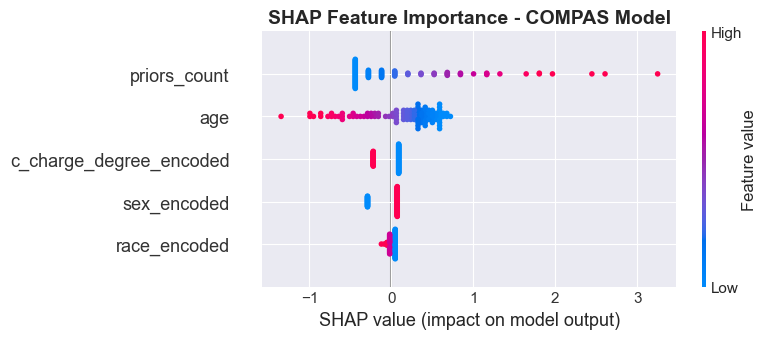


✓ SHAP analysis complete for COMPAS model


In [18]:
print("="*80)
print("MODEL EXPLAINABILITY - SHAP ANALYSIS (COMPAS)")
print("="*80)

# Create SHAP explainer
print("\nGenerating SHAP explanations (this may take a moment)...")
explainer_c = shap.LinearExplainer(lr_compas, X_train_c_scaled)
shap_values_c = explainer_c.shap_values(X_test_c_scaled[:100])  # Use subset for speed

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_c, X_test_c.iloc[:100], 
                  feature_names=feature_cols_compas, show=False)
plt.title('SHAP Feature Importance - COMPAS Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ SHAP analysis complete for COMPAS model")

### 9.2 LIME Explainability for Adult Model

MODEL EXPLAINABILITY - LIME ANALYSIS (ADULT)

Generating LIME explanation for a sample prediction...

📊 LIME Explanation for Sample Instance:
   Predicted Class: <=50K
   Actual Class: <=50K

   Feature Contributions:
   • capital-gain <= -0.15: -0.6975
   • hours-per-week <= -0.08: -0.0877
   • -0.05 < education-num <= 1.13: 0.0580
   • -0.80 < age <= -0.11: -0.0171
   • -1.44 < sex_encoded <= 0.70: 0.0049
   • race_encoded <= 0.39: 0.0000


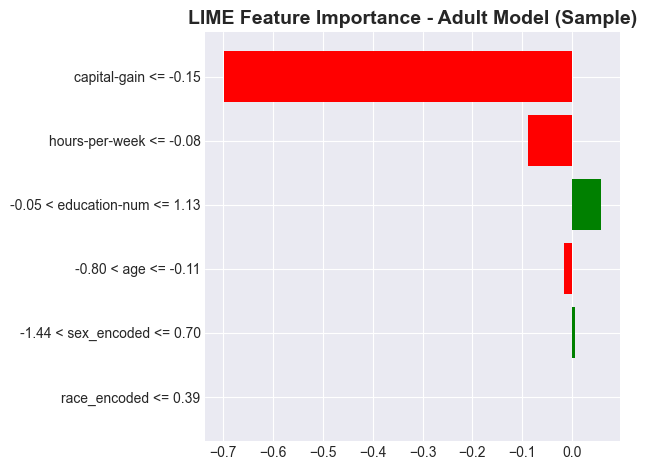


✓ LIME analysis complete for Adult model


In [19]:
print("="*80)
print("MODEL EXPLAINABILITY - LIME ANALYSIS (ADULT)")
print("="*80)

# Create LIME explainer
print("\nGenerating LIME explanation for a sample prediction...")
lime_explainer = LimeTabularExplainer(
    X_train_a_scaled,
    feature_names=feature_cols_adult,
    class_names=['<=50K', '>50K'],
    mode='classification'
)

# Explain a single instance
sample_idx = 0
lime_exp = lime_explainer.explain_instance(
    X_test_a_scaled[sample_idx],
    rf_adult.predict_proba,
    num_features=6
)

# Display explanation
print("\n📊 LIME Explanation for Sample Instance:")
print(f"   Predicted Class: {'>50K' if y_pred_a[sample_idx] == 1 else '<=50K'}")
print(f"   Actual Class: {'>50K' if y_test_a.iloc[sample_idx] == 1 else '<=50K'}")
print("\n   Feature Contributions:")
for feature, weight in lime_exp.as_list():
    print(f"   • {feature}: {weight:.4f}")

# Visualize
fig = lime_exp.as_pyplot_figure()
plt.title('LIME Feature Importance - Adult Model (Sample)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ LIME analysis complete for Adult model")

## Pending Tasks

### 1. Comprehensive Evaluation Report
### 2. Export Results and Artifacts